In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from transformers.testing_utils import torch_device

In [10]:
def calculate_accuracy(model):
    """특정 모델에 대한 정확도를 계산하고 출력합니다."""
    df = pd.read_csv(f"../data/train_add-{model}-answer.csv")
    df["original_answer"] = df["problems"].apply(lambda x: ast.literal_eval(x)["answer"])
    df["is_correct"] = df["original_answer"].astype(str) == df[f"{model}_answer"].astype(str)
    correct_count = df["is_correct"].sum()
    total_count = len(df)
    accuracy = correct_count / total_count * 100
    print(f"Model: {model}\nTotal Questions: {total_count}\nCorrect Answers: {correct_count}\nAccuracy: {accuracy:.2f}%\n")

def calculate_accuracy_and_errors(model):
    """특정 모델에 대한 오답 데이터프레임을 반환합니다."""
    df = pd.read_csv(f"../data/train_add-{model}-answer.csv")
    df["original_answer"] = df["problems"].apply(lambda x: ast.literal_eval(x)["answer"])
    df["is_correct"] = df["original_answer"].astype(str) == df[f"{model}_answer"].astype(str)
    errors_df = df[~df["is_correct"]].copy()
    errors_df[f"{model}_answer"] = df[f"{model}_answer"]
    return errors_df[["id", "original_answer", f"{model}_answer"]]

def save_filtered_data(errors_df_list, min_models_incorrect, output_filename):
    """특정 모델 수 이상이 틀린 문제를 제외하고 데이터를 저장하며 통계를 출력합니다."""
    train_df = pd.read_csv("../data/train.csv")
    total_count = len(train_df)

    # 각 모델의 오답을 하나의 데이터프레임으로 결합하고, ID별로 오답 횟수를 계산
    all_errors = pd.concat([errors_df[["id", "original_answer"]] for errors_df in errors_df_list])
    error_counts = all_errors.groupby("id").size()

    # 지정된 모델 수 이상이 틀린 문제의 ID만 선택
    if min_models_incorrect == len(errors_df_list):
        condition_text = "모든 모델이 틀린 문제"
    else:
        condition_text = f"{min_models_incorrect}개 이상의 모델이 틀린 문제"
    exclude_ids = error_counts[error_counts >= min_models_incorrect].index

    # 조건에 해당하는 문제를 제외하고 데이터 필터링
    filtered_df = train_df[~train_df["id"].isin(exclude_ids)]
    filtered_count = len(filtered_df)
    excluded_count = len(exclude_ids)

    # 결과 저장 및 출력
    filtered_df.to_csv(f"../data/{output_filename}", index=False)
    print(f"조건: {condition_text} 제외")
    print(f"전체 문제 수: {total_count}")
    print(f"제외된 문제 수: {excluded_count}")
    print(f"저장된 문제 수: {filtered_count}")
    print(f"필터링된 데이터가 {output_filename} 파일에 저장되었습니다.\n")

In [5]:
calculate_accuracy("gpt-3.5-turbo")
calculate_accuracy("gpt-4o")
calculate_accuracy("gpt-4o-mini")

Model: gpt-3.5-turbo
Total Questions: 2031
Correct Answers: 1530
Accuracy: 75.33%

Model: gpt-4o
Total Questions: 2031
Correct Answers: 1841
Accuracy: 90.65%

Model: gpt-4o-mini
Total Questions: 2031
Correct Answers: 1788
Accuracy: 88.04%



In [6]:
errors_gpt3 = calculate_accuracy_and_errors("gpt-3.5-turbo")
errors_gpt4 = calculate_accuracy_and_errors("gpt-4o")
errors_gpt4_mini = calculate_accuracy_and_errors("gpt-4o-mini")

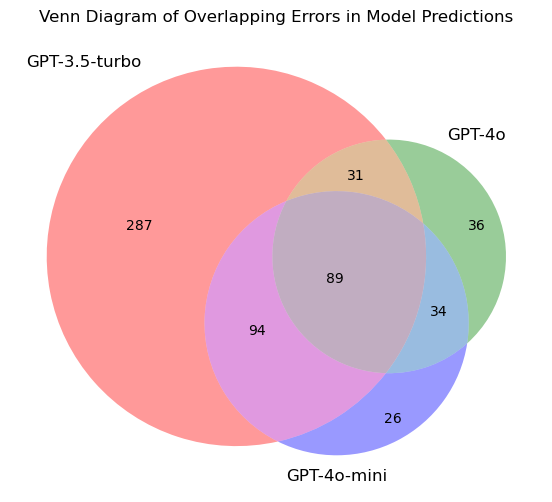

In [7]:
# 개별 오답 개수
gpt3_errors_count = len(errors_gpt3)
gpt4_errors_count = len(errors_gpt4)
gpt4_mini_errors_count = len(errors_gpt4_mini)

# 모델 간 겹치는 오답 계산
gpt3_gpt4_overlap_df = errors_gpt3.merge(errors_gpt4, on=["id", "original_answer"], how="inner",
                                         suffixes=("_gpt3", "_gpt4"))
gpt3_gpt4_mini_overlap_df = errors_gpt3.merge(errors_gpt4_mini, on=["id", "original_answer"], how="inner",
                                              suffixes=("_gpt3", "_gpt4_mini"))
gpt4_gpt4_mini_overlap_df = errors_gpt4.merge(errors_gpt4_mini, on=["id", "original_answer"], how="inner",
                                              suffixes=("_gpt4", "_gpt4_mini"))
all_overlap_df = gpt3_gpt4_overlap_df.merge(errors_gpt4_mini, on=["id", "original_answer"], how="inner")

# 겹치는 오답 개수
gpt3_gpt4_overlap = len(gpt3_gpt4_overlap_df)
gpt3_gpt4_mini_overlap = len(gpt3_gpt4_mini_overlap_df)
gpt4_gpt4_mini_overlap = len(gpt4_gpt4_mini_overlap_df)
all_overlap = len(all_overlap_df)

plt.figure(figsize=(8, 6))
venn = venn3(subsets=(
    gpt3_errors_count - gpt3_gpt4_overlap - gpt3_gpt4_mini_overlap + all_overlap,  # GPT-3.5-turbo만 틀린 문제 수
    gpt4_errors_count - gpt3_gpt4_overlap - gpt4_gpt4_mini_overlap + all_overlap,  # GPT-4o만 틀린 문제 수
    gpt3_gpt4_overlap - all_overlap,  # GPT-3.5-turbo와 GPT-4o가 둘 다 틀린 문제 수
    gpt4_mini_errors_count - gpt3_gpt4_mini_overlap - gpt4_gpt4_mini_overlap + all_overlap,  # GPT-4o-mini만 틀린 문제 수
    gpt3_gpt4_mini_overlap - all_overlap,  # GPT-3.5-turbo와 GPT-4o-mini가 둘 다 틀린 문제 수
    gpt4_gpt4_mini_overlap - all_overlap,  # GPT-4o와 GPT-4o-mini가 둘 다 틀린 문제 수
    all_overlap  # 세 모델 모두 틀린 문제 수
), set_labels=("GPT-3.5-turbo", "GPT-4o", "GPT-4o-mini"))
plt.title("Venn Diagram of Overlapping Errors in Model Predictions")
plt.savefig("../data/model_errors_venn_diagram.png", format="png", dpi=300)
plt.show()

In [11]:
# 모든 모델이 틀린 문제를 제외하고 저장
save_filtered_data([errors_gpt3, errors_gpt4, errors_gpt4_mini], min_models_incorrect=3, output_filename="no_all_errors.csv")

# 두 개 이상의 모델이 틀린 문제를 제외하고 저장
save_filtered_data([errors_gpt3, errors_gpt4, errors_gpt4_mini], min_models_incorrect=2, output_filename="no_two_or_more_errors.csv")

조건: 모든 모델이 틀린 문제 제외
전체 문제 수: 2031
제외된 문제 수: 89
저장된 문제 수: 1942
필터링된 데이터가 no_all_errors.csv 파일에 저장되었습니다.

조건: 2개 이상의 모델이 틀린 문제 제외
전체 문제 수: 2031
제외된 문제 수: 248
저장된 문제 수: 1783
필터링된 데이터가 no_two_or_more_errors.csv 파일에 저장되었습니다.

